### Imports

In [1]:
#importing things
import pandas as pd
import numpy as np
import csv
import pylab as pl
import matplotlib.pyplot as plt
import copy
import scipy
from collections import OrderedDict
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.special import comb
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.lines as lines

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'xtick.labelsize': 7})
plt.rcParams.update({'ytick.labelsize': 7})
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5

### Load structure with selected regions and mutated residues

In [2]:
#pick an antigen
antigen = "SI06"
#import stuff
from pymol import cmd
#load pdb
if antigen == "SI06":
    cmd.fetch('5UGY')
    cmd.hide('everything')
    HA = cmd.select('HA', ('chain A or chain B'))
    ##########################
    #create selections for mutated residues
    mut1 = cmd.select('N26D',('chain L and resi 26'))
    mut2 = cmd.select('S29R',('chain L and resi 29'))
    mut3 = cmd.select('Y35N',('chain L and resi 35'))
    mut4 = cmd.select('Y48C',('chain L and resi 48'))
    mut5 = cmd.select('D49Y',('chain L and resi 49'))
    mut6 = cmd.select('V98I',('chain L and resi 98'))
    mut7 = cmd.select('G31D',('chain H and resi 31'))
    mut8 = cmd.select('Y33H',('chain H and resi 33'))
    mut9 = cmd.select('M34I',('chain H and resi 34'))
    mut10 = cmd.select('H35N',('chain H and resi 35'))
    mut11 = cmd.select('N52H',('chain H and resi 52'))
    mut12 = cmd.select('G57D',('chain H and resi 57'))
    mut13 = cmd.select('L83V',('chain H and resi 83'))
    mut14 = cmd.select('S84N',('chain H and resi 84'))
    mut15 = cmd.select('R85G',('chain H and resi 85'))
    mut16 = cmd.select('R87K',('chain H and resi 87'))
    mutations = ['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I','H35N','N52H','G57D','L83V','S84N','R85G','R87K']
#     cmd.png('/tmp/foo.png', ray=1)
#     from IPython.display import Image
#     Image(filename='/tmp/foo.png')

## second order versus pairwise plot

In [3]:
model = "biochem"
plotting = "pairwise"
mut_names = ['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I','H35N','G57D','L83V','S84N','R85G','R87K']
if antigen == "SI06":
    h1 = pd.read_table('../../../Epistasis_Inference/SI06/biochemical/CH65_SI06_102022_5order_biochem_reindexed.txt',names=['Term','SI06_Effect','SI06_SE','pval','SI06_95CI_low','SI06_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
    h1['order'] = h1[['Term']].applymap(lambda x: str.count(x, ',')+1)
    h1_pairwise = h1[h1['order']==2]
    h1_pairwise[['Mutation 1','Mutation 2']] = h1_pairwise.Term.str.split(",",expand=True)
    toplot = pd.DataFrame()
    toplot = h1_pairwise[['Mutation 1','Mutation 2','SI06_Effect','SI06_SE','SI06_95CI_low','SI06_95CI_hi']].copy()
    toplot['Mutation 1'] = toplot['Mutation 1'].replace({'1':'N26D','2':'S29R','3':'Y35N','4':'Y48C','5':'D49Y','6':'V98I','7':'G31D','8':'Y33H','9':'M34I','10':'H35N','11':'N52H','12':'G57D','13':'L83V','14':'S84N','15':'R85G','16':'R87K'})
    toplot['Mutation 2'] = toplot['Mutation 2'].replace({'1':'N26D','2':'S29R','3':'Y35N','4':'Y48C','5':'D49Y','6':'V98I','7':'G31D','8':'Y33H','9':'M34I','10':'H35N','11':'N52H','12':'G57D','13':'L83V','14':'S84N','15':'R85G','16':'R87K'})
    mask = (toplot['SI06_95CI_low'] <= 0) & (toplot['SI06_95CI_hi'] >=0)
    toplot['SI06_Effect'][mask] = 0

/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_33768/1271013437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h1_pairwise[['Mutation 1','Mutation 2']] = h1_pairwise.Term.str.split(",",expand=True)
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_33768/1271013437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h1_pairwise[['Mutation 1','Mutation 2']] = h1_pairwise.Term.str.split(",",expand=True)
/var/folders/pt/19trqkw56fjfrk2frchqhv2h0000gn/T/ipykernel_33768/1271013437.py:14:

### Measure distance between alpha carbons

In [4]:
distance_log=[]
loc_muta = list(toplot['Mutation 1'])
loc_mutb = list(toplot['Mutation 2'])
epistasis = list(toplot['%s_Effect' % antigen])
labels=[]
for l in range(len(loc_muta)):
    var1=loc_muta[l]
    var2=loc_mutb[l]
    label = str(var1)+','+str(var2)
    labels.append(label)
    distance=cmd.distance(None, "%s and n. CA"%var1, "%s and n. CA"%var2) #distance between alpha carbons
    distance_log.append(distance)
df_toplot=pd.DataFrame()
df_toplot['labels']=labels
df_toplot['distance']=distance_log
df_toplot['epistasis']= epistasis
df_toplot.dropna(inplace=True)
s = df_toplot.sort_values(by='epistasis',ascending=False)
s.to_csv('2ndorder_summary%s.csv'% antigen,index=False)

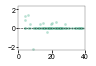

In [5]:
#sort dataframe to only label outliers
df_toplot_s = df_toplot.iloc[(-df_toplot['epistasis'].abs()).argsort()].reset_index(drop=True)

#number of outliers to label
if antigen=="SI06":
    spot = "#72C2A6"
    edge = "#72C2A6"
lim = 5
%matplotlib inline
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.25
fig, ax = plt.subplots(figsize=(1.2,0.8))
plt.tick_params(labelsize=7,length=2.5,pad=0.5)


lim=0
for line in range(0,lim):
    ax.text(df_toplot_s.distance[line]+0.55, df_toplot_s.epistasis[line], df_toplot_s.labels[line], horizontalalignment='center', fontsize=4, color='black')

#Create figure
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(x=df_toplot_s.distance, y=df_toplot_s.epistasis, alpha = 0.5, linewidth=0.25,color=spot,edgecolor=edge,s=5,legend=False)
#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylim(-2.3,2.3)
plt.xlim(0,40)
ax.set_xlabel('',fontsize=7,labelpad=0)
if plotting == "sum":
    ax.set_ylabel('weighted epistasis',fontsize=7)
else:
    ax.set_ylabel('',fontsize=7,labelpad=0)

plt.savefig('images/SI06_%s_2ndorder_structure.png'% antigen, transparent=True, dpi=1200,bbox_inches='tight')

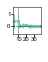

In [6]:
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()

plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=6,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['distance'].mean()
plt.scatter(x,y,color=spot,s=5)
plt.errorbar(x,y,yerr,color=spot,linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/SI06_%s_2ndorder_structure_binned.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')


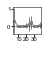

In [7]:
#permute for control
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()
df_toplot_pos['permuted'] = np.random.permutation(df_toplot_pos['distance'].values)
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=6,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['permuted'].mean()
plt.scatter(x,y,color='gray',s=5)
plt.errorbar(x,y,yerr,color='gray',linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/SI06_%s_2ndorder_structure_binned_permuted.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')
